<a href="https://colab.research.google.com/github/ejrtks1020/Computer_Vision_Project/blob/main/Face-Mask-Detection/Face_Mask_Detection_Train_and_Test(Faster_R_CNN).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 5. Face Mask Detection (Faster R-CNN)

In [ ]:
!pip uninstall opencv-python-headless==4.5.5.62 
!pip install opencv-python-headless==4.1.2.30

In [ ]:
!pip install --upgrade albumentations

# 5.1. 데이터 불러오기

In [ ]:
import os

os.environ['KAGGLE_USERNAME'] = 'asdsadwqrr'
os.environ['KAGGLE_KEY'] = 'fcd162570bf9e9f427cde4418405b341'

In [ ]:
!kaggle datasets download -d andrewmvd/face-mask-detection

 96% 382M/398M [00:01<00:00, 233MB/s]
100% 398M/398M [00:01<00:00, 226MB/s]


In [ ]:
!mkdir mask_dataset

In [ ]:
!unzip face-mask-detection.zip -d mask_dataset

In [ ]:
import cv2
import os
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches
import torch
from bs4 import BeautifulSoup
from PIL import Image
import numpy as np
import time
import torchvision
from torch.utils.data import Dataset
from torchvision import transforms
import albumentations
import albumentations.pytorch
import random
import torch

In [ ]:
def generate_box(obj):
  xmin = float(obj.find('xmin').text)
  ymin = float(obj.find('ymin').text)
  xmax = float(obj.find('xmax').text)
  ymax = float(obj.find('ymax').text)
  return [xmin, ymin, xmax, ymax]

# background label이 0이므로 각 레이블에 1씩 더한다
adjust_label = 1
def generate_label(obj):
  if obj.find('name').text == 'with_mask':
    return 1 + adjust_label
  elif obj.find('name').text == 'mask_weared_incorrect':
    return 2 + adjust_label
  return 0 + adjust_label

def generate_target(file):
  with open(file) as f:
    data = f.read()
    soup = BeautifulSoup(data, 'html.parser')
    objects = soup.find_all('object')

    num_objs = len(objects)

    boxes = []
    labels = []
    #각 오브젝트에서 바운딩박스와 label 추출
    for i in objects:
      boxes.append(generate_box(i))
      labels.append(generate_label(i))
    
    boxes = torch.as_tensor(boxes, dtype = torch.float32) # 추후 딥러닝 모델학습을 위한 tensor간 연산을 위해 tensor로 변환
    labels = torch.as_tensor(labels, dtype = torch.int64)

    target = {}
    target["boxes"] = boxes
    target["labels"] = labels
    return target

In [ ]:
def plot_image_from_output_cv(img, annotation):
  img = img.permute(1, 2, 0)
  img = img.to('cpu')
  img2 = np.array(img.numpy() * 255, dtype = np.uint8)
  img_bgr = cv2.cvtColor(img2, cv2.COLOR_RGB2BGR)

  for i in range(len(annotation['boxes'])):
    bbox = annotation['boxes'][i]
    left = int(bbox[0])
    top = int(bbox[1])
    right = int(bbox[2])
    bottom = int(bbox[3])
    
    if annotation['labels'][i] == 1:
      color = (0, 0, 255) # red color
      text = 'without_mask'
    elif annotation['labels'][i] == 2:
      color = (0, 255, 0) # green color
      text = 'with_mask'
    else:
      color = (255, 0, 0) # blue color
      text = 'mask_incorrect'
    cv2.rectangle(img_bgr, (left, top), (right, bottom), color = color, thickness = 1)

    cv2.putText(img_bgr, text, (left, top - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.4,color = color, thickness = 1)
  img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
  plt.figure(figsize = (10, 10))
  plt.imshow(img_rgb)

# 5.2. 데이터 분리

In [ ]:
img_list = sorted(glob.glob('mask_dataset/images/*'))
annot_list = sorted(glob.glob('mask_dataset/annotations/*'))

In [ ]:
%cd mask_dataset
!mkdir test_annotations; mkdir test_images

/content/mask_dataset


In [ ]:
# 전체 데이터셋 개수가 적으므로 8:2 비율로 테스트 데이터를 생성한다
from sklearn.model_selection import train_test_split
train_idx , test_idx = train_test_split(range(853), test_size = 0.2 ,random_state = 1234)

In [ ]:
len(train_idx), len(test_idx)

(682, 171)

In [ ]:
test_idx[:10]

[620, 534, 348, 148, 230, 277, 322, 503, 501, 89]

In [ ]:
import shutil
for img in np.array(sorted(os.listdir('images')))[test_idx]:
  shutil.move('images/' + img, 'test_images/' + img)

for img in np.array(sorted(os.listdir('annotations')))[test_idx]:
  shutil.move('annotations/' + img, 'test_annotations/' + img)

In [ ]:
#각 디렉토리 파일 개수 확인
print(len(os.listdir('annotations')))
print(len(os.listdir('images')))
print(len(os.listdir('test_images')))
print(len(os.listdir('test_annotations')))

682
682
171
171


In [ ]:
!pwd
%cd ..

/content/mask_dataset
/content


# 5.3. 데이터셋 클래스 정의

In [ ]:
class MaskDataset(Dataset):
    def __init__(self, path, transform=None):
        self.path = path
        self.imgs = list(sorted(os.listdir(self.path)))
        self.transform = transform
        
    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        file_image = self.imgs[idx]
        file_label = self.imgs[idx][:-3] + 'xml'
        img_path = os.path.join(self.path, file_image)

        if 'test' in self.path:
            label_path = os.path.join("/content/mask_dataset/test_annotations/", file_label)
        else:
            label_path = os.path.join("/content/mask_dataset/annotations/", file_label)
        
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        target = generate_target(label_path)

        to_tensor = torchvision.transforms.ToTensor() # numpy 이미지에서 torch이미지로 변경

        if self.transform:
            image , transform_target = self.transform(image = np.array(image), bboxes = np.array(target['boxes']))
            target['boxes'] = torch.as_tensor(transform_target)
        
        # tensor로 변경
        image = to_tensor(image)

        return image, target

def collate_fn(batch):
  return tuple(zip(*batch))

In [ ]:
dataset = MaskDataset('/content/mask_dataset/images/')
test_dataset = MaskDataset('/content/mask_dataset/test_images/')

# 최종적으로 학습용 데이터와 테스트용 데이터를 배치단위로 불러올수 있게 DataLoader함수를 사용
data_loader = torch.utils.data.DataLoader(dataset, batch_size = 2, collate_fn=collate_fn)
test_data_loader = torch.utils.data.DataLoader(test_dataset, batch_size = 2, collate_fn=collate_fn)

In [ ]:
if torch.cuda.is_available():
  device = torch.device('cuda')
  print('There are %d GPU(s) avaliable.' % torch.cuda.device_count())
  print('We will use the GPU:', torch.cuda.get_device_name(0))
else:
  print('No GPU available, using the CPU instead')
  device = torch.device('cpu')

There are 1 GPU(s) avaliable.
We will use the GPU: Tesla P100-PCIE-16GB


# 5.4. 모델 불러오기

In [ ]:
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
def get_model_obj_detection(num_classes):

  # backbone : ResNet50 , COCO 2017 Dataset으로 사전학습된 모델을 가져온다.
  model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained = True)
  in_features = model.roi_heads.box_predictor.cls_score.in_features
  model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
  
  return model

## 5.5 전이 학습

In [ ]:
# num classes는 백그라운드 클래스를 포함해서 4개
model = get_model_obj_detection(4)
model.to(device)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


  0%|          | 0.00/160M [00:00<?, ?B/s]

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [ ]:
num_epochs = 10
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr = 0.001,
                            momentum = 0.9, weight_decay = 0.0005)

In [ ]:
model.train()
imgs , annots = next(iter(data_loader))
imgs = list(img.to(device) for img in imgs)
annots = [{k: v.to(device) for k, v in t.items()} for t in annots]

In [ ]:
loss_dict = model(imgs, annots)

In [ ]:
loss_dict

{'loss_box_reg': tensor(0.1199, device='cuda:0', grad_fn=<DivBackward0>),
 'loss_classifier': tensor(1.4185, device='cuda:0', grad_fn=<NllLossBackward0>),
 'loss_objectness': tensor(0.1017, device='cuda:0',
        grad_fn=<BinaryCrossEntropyWithLogitsBackward0>),
 'loss_rpn_box_reg': tensor(0.0355, device='cuda:0', grad_fn=<DivBackward0>)}

In [ ]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [ ]:
print('ㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡTrain Startㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡ')
for epoch in range(num_epochs):
  start = time.time()
  model.train()

  epoch_loss = 0
  for imgs, annotations in data_loader:
    imgs = list(img.to(device) for img in imgs)
    annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
    loss_dict = model(imgs, annotations)
    losses = sum(loss for loss in loss_dict.values())

    optimizer.zero_grad()
    losses.backward()
    optimizer.step()
    epoch_loss += losses
  
  print(f'epoch : {epoch + 1}, Loss : {epoch_loss}, time : {time.time() - start}')

ㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡTrain Startㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡ
epoch : 1, Loss : 152.087646484375, time : 125.16126894950867
epoch : 2, Loss : 99.41278076171875, time : 124.65226864814758
epoch : 3, Loss : 85.04033660888672, time : 124.74183630943298
epoch : 4, Loss : 75.20567321777344, time : 126.03759098052979
epoch : 5, Loss : 67.19242858886719, time : 125.73823428153992
epoch : 6, Loss : 60.276817321777344, time : 126.1106436252594
epoch : 7, Loss : 56.963592529296875, time : 125.52280759811401
epoch : 8, Loss : 57.347896575927734, time : 124.75366854667664
epoch : 9, Loss : 51.58095932006836, time : 124.63084816932678
epoch : 10, Loss : 48.098899841308594, time : 124.60724329948425


In [ ]:
torch.save(model.state_dict(), f'/content/drive/MyDrive/mask_save/model_Faster_RCNN_{num_epochs}.pt')

# 5.6. 예측


In [ ]:
num_epochs = 10

In [ ]:
model.load_state_dict(torch.load(f'/content/drive/MyDrive/mask_save/model_Faster_RCNN_{num_epochs}.pt'))

<All keys matched successfully>

In [ ]:
def make_prediction(model, img, threshold):
    model.eval()
    preds = model(img)
    for id in range(len(preds)) :
        idx_list = []

        for idx, score in enumerate(preds[id]['scores']) :
            if score > threshold : 
                idx_list.append(idx)

        preds[id]['boxes'] = preds[id]['boxes'][idx_list]
        preds[id]['labels'] = preds[id]['labels'][idx_list]
        preds[id]['scores'] = preds[id]['scores'][idx_list]

    return preds

In [ ]:
with torch.no_grad():
  for imgs, annotations in test_data_loader:
    imgs = list(img.to(device) for img in imgs)

    pred = make_prediction(model, imgs, 0.5)
    print(pred)
    break

[{'boxes': tensor([[219.5792,  99.1660, 257.5327, 137.8085],
        [130.4514, 109.8180, 178.2516, 152.1632],
        [ 41.7928, 108.8688,  65.8802, 141.6052],
        [303.0098, 130.5367, 331.3535, 158.3930],
        [165.5083,  90.3567, 180.0772, 107.4943],
        [ 29.7025,  89.1168,  45.5423, 103.9992],
        [ 83.8182,  84.6521,  95.0342,  96.4302],
        [  3.1532, 103.5543,  21.4233, 126.8428],
        [258.6207,  90.4170, 268.3104, 101.7531],
        [  1.9784, 104.1239,  21.7895, 125.2218]], device='cuda:0'), 'labels': tensor([2, 2, 1, 1, 1, 1, 1, 1, 1, 3], device='cuda:0'), 'scores': tensor([0.9968, 0.9949, 0.9855, 0.9767, 0.9479, 0.9338, 0.9044, 0.7483, 0.5137,
        0.5003], device='cuda:0')}, {'boxes': tensor([[159.4526,  68.9255, 420.3548, 378.8495]], device='cuda:0'), 'labels': tensor([2], device='cuda:0'), 'scores': tensor([0.8897], device='cuda:0')}]


/usr/local/lib/python3.7/dist-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Target :  tensor([1, 1, 1, 2, 2, 1, 1, 1])
Prediction :  tensor([2, 2, 1, 1, 1, 1, 1, 1, 1, 3], device='cuda:0')


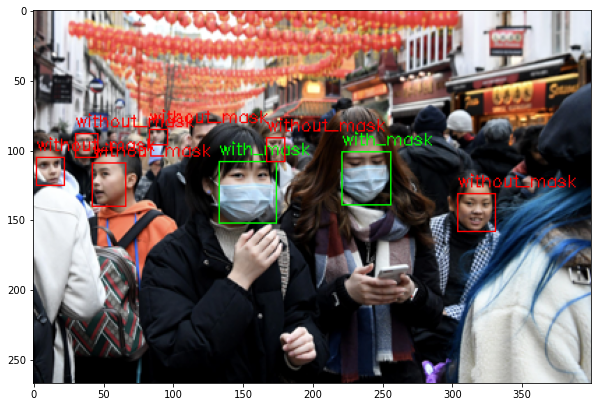

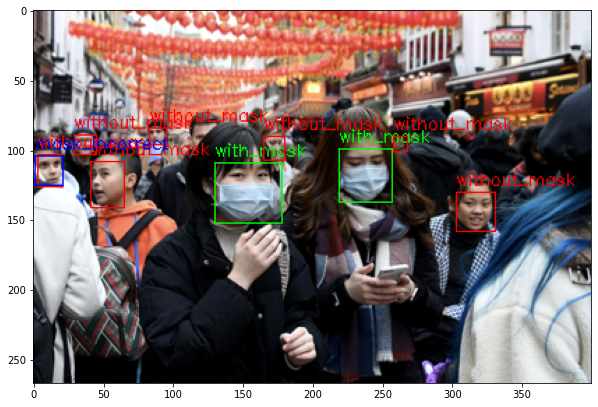

In [ ]:
print("Target : ", annotations[0]['labels'])
plot_image_from_output_cv(imgs[0], annotations[0])
print("Prediction : ", pred[0]['labels'])
plot_image_from_output_cv(imgs[0], pred[0])

In [ ]:
from tqdm import tqdm
labels = []
preds_adj_all = []
annot_all = []

for im, annot in tqdm(test_data_loader, position = 0, leave = True):
    im = list(img.to(device) for img in im)
    #annot = [{k: v.to(device) for k, v in t.items()} for t in annot]

    for t in annot:
        labels += t['labels']

    with torch.no_grad():
        preds_adj = make_prediction(model, im, 0.5)
        preds_adj = [{k: v.to(torch.device('cpu')) for k, v in t.items()} for t in preds_adj]
        preds_adj_all.append(preds_adj)
        annot_all.append(annot)

100%|██████████| 86/86 [00:17<00:00,  4.84it/s]


In [ ]:
len(preds_adj_all)

86

In [ ]:
def plot_image_from_output_cv_2(img, annotation):
  img = img.permute(1, 2, 0)
  img = img.to('cpu')
  img2 = np.array(img.numpy() * 255, dtype = np.uint8)
  img_bgr = cv2.cvtColor(img2, cv2.COLOR_RGB2BGR)

  for i in range(len(annotation['boxes'])):
    bbox = annotation['boxes'][i]
    left = int(bbox[0])
    top = int(bbox[1])
    right = int(bbox[2])
    bottom = int(bbox[3])
    
    if annotation['labels'][i] == 1:
      color = (0, 0, 255) # red color
      text = 'without_mask'
    elif annotation['labels'][i] == 2:
      color = (0, 255, 0) # green color
      text = 'with_mask'
    else:
      color = (255, 0, 0) # blue color
      text = 'mask_incorrect'
    cv2.rectangle(img_bgr, (left, top), (right, bottom), color = color, thickness = 1)

    cv2.putText(img_bgr, text, (left, top - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.4,color = color, thickness = 1)
  img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
  return img_rgb

In [ ]:
!mkdir test_imgs
%cd test_imgs
!mkdir gt_imgs; mkdir pred_imgs

/content/test_imgs


In [ ]:
%cd ..

/content


In [ ]:
test_dataset = MaskDataset('/content/mask_dataset/test_images/')

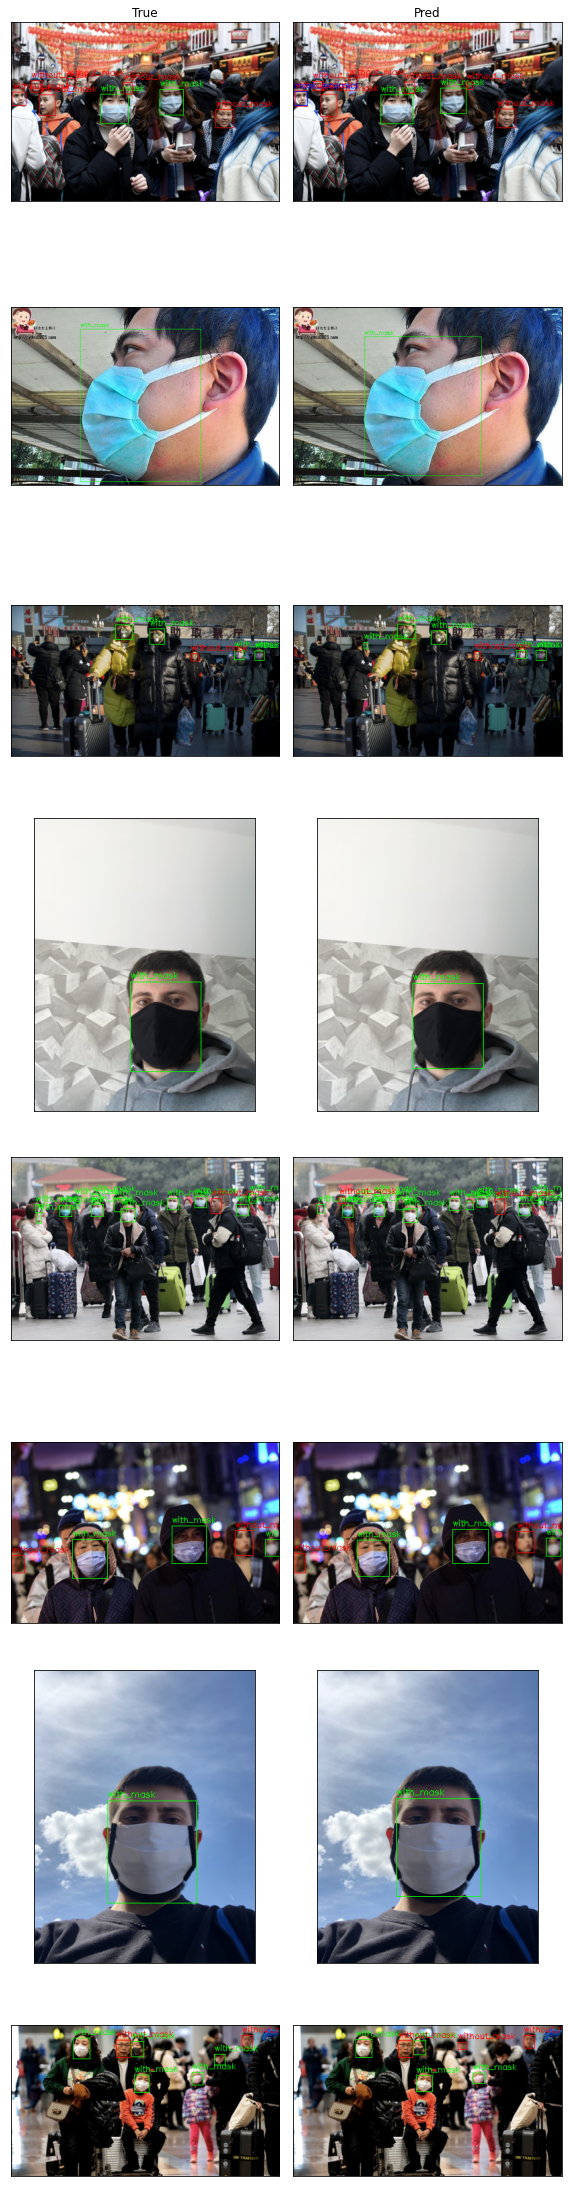

In [ ]:
import imageio

nrows = 8
ncols = 2
fig, axes = plt.subplots(nrows = 8, ncols = 2, figsize = (ncols * 4, nrows * 4))

batch_i = 0
row = 0
img_num = 1
for im, annot in test_data_loader:

  for sample_i in range(len(im)):

    img1 = plot_image_from_output_cv_2(im[sample_i], annot[sample_i])
    img2 = plot_image_from_output_cv_2(im[sample_i], preds_adj_all[batch_i][sample_i])
    if batch_i < 4:
      axes[row, 0].imshow(img1)
      axes[row, 1].imshow(img2)

    row += 1
    img_num += 1
    
    #prediction 결과를 파일로 저장
    imageio.imwrite('/content/test_imgs/gt_imgs/' + str(img_num) +'.jpg', img1)
    imageio.imwrite('/content/test_imgs/pred_imgs/' + str(img_num) + '.jpg', img2) 
  batch_i += 1
#  if batch_i == 4:
#    break

for idx, ax in enumerate(axes.flat):
  ax.set_xticks([])
  ax.set_yticks([])

colnames = ['True', 'Pred']
for idx, ax in enumerate(axes[0]):
  ax.set_title(colnames[idx])

plt.tight_layout()
plt.show()

예측결과 폴더 압출후 다운로드

In [ ]:
!zip -r /content/test_image_predict_result.zip /content/test_imgs

In [ ]:
from google.colab import files
files.download("/content/test_image_predict_result.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
!git clone https://github.com/Pseudo-Lab/Tutorial-Book-Utils

Cloning into 'Tutorial-Book-Utils'...
remote: Enumerating objects: 30, done.
remote: Counting objects: 100% (30/30), done.
remote: Compressing objects: 100% (24/24), done.
remote: Total 30 (delta 9), reused 18 (delta 5), pack-reused 0
Unpacking objects: 100% (30/30), done.


In [ ]:
%cd Tutorial-Book-Utils/
import utils_ObjectDetection as utils

/content/Tutorial-Book-Utils


In [ ]:
sample_metrics = []
for batch_i in range(len(preds_adj_all)):
    sample_metrics += utils.get_batch_statistics(preds_adj_all[batch_i], annot_all[batch_i], iou_threshold=0.5) 

true_positives, pred_scores, pred_labels = [torch.cat(x, 0) for x in list(zip(*sample_metrics))]  # 배치가 전부 합쳐짐
precision, recall, AP, f1, ap_class = utils.ap_per_class(true_positives, pred_scores, pred_labels, torch.tensor(labels))
mAP = torch.mean(AP)
print(f'mAP : {mAP}')
print(f'AP : {AP}')

mAP : 0.6683995379461689
AP : tensor([0.8391, 0.9519, 0.2143], dtype=torch.float64)


* 10번만 학습했음에도 30번 학습한 RetinaNet보다 더 나은 결과를 보인다.
* 0번 (마스크 미착용) 클래스 : 0.84 AP
* 1번 (마스크 착용) 클래스 : 0.95 AP
* 2번 (마스크 오착용) 클래스 : 0.21 AP

 마스크 오착용 오브젝트에 대해 다른 두 클래스 보다 상대적으로 낮은 성능을 보이고 있으나, 이 데이터 셋에는 Faster RCNN이 더 좋은 성능을 보이고 있다.